In [1]:
# Entities
import numpy as np
import torch

from processing.robotics.arm_propagator import ArmPropagator, ElectromagnetEndEffector
from processing.system_animation import animate_system
from processing.utilities.entities import Cylinder

# Attitude
from processing.attitude.attitude_propagator import AttitudePropagator
from processing.attitude.torques.base import TorqueObject
from processing.attitude.torques.eddy_current import EddyCurrentTorque

# Environment
from propagator.bin.environment import Environment

In [2]:
def save_step(t: float, prop: list, at: AttitudePropagator, ar: ArmPropagator):
    # Convert to numpy
    prop = np.array(prop)

    # Save arm
    if ar._timestamps is None:
        ar._timestamps = np.array([t])
        ar._prop_sol = prop[0:12].reshape(-1, 1)
    else:
        ar._timestamps = np.hstack((ar._timestamps, np.array([t])))
        ar._prop_sol = np.hstack((ar._prop_sol, prop[0:12].reshape(-1, 1)))

    # Save end effector results
    ar.end_effector._timestamps = ar._timestamps
    if ar.end_effector.locations is None:
        ar.end_effector.locations = prop[19:22].reshape(-1, 1)
        ar.end_effector.poses = prop[22:25].reshape(-1, 1)
    else:
        ar.end_effector.locations = np.hstack((ar.end_effector.locations, prop[19:22].reshape(-1, 1)))
        ar.end_effector.poses = np.hstack((ar.end_effector.poses, prop[22:25].reshape(-1, 1)))

    # Save attitude
    at._timestamps = ar._timestamps
    if at._prop_sol is None:
        at._prop_sol = prop[12:19].reshape(-1, 1)
    else:
        at._prop_sol = np.hstack((at._prop_sol, prop[12:19].reshape(-1, 1)))

    return

# System setup

In [3]:
# Generate debris
debris = Cylinder(
    mass=950.0,
    radius=2.5,
    height=5.0,
    thickness=0.1,
    sigma=35000000.0
)

# Generate robotic arms (UR10 standard)
# Joints
# TODO: Consider adjusting the scaling and the inertia matrices by considering a cylindrical simplified model
scale = 10
joints = np.array([
    [0, 0, scale*0.1807, np.pi/2],
    [0, scale*-0.6127, 0, 0],
    [0, scale*-0.57155, 0, 0],
    [0, 0, scale*0.17415, np.pi/2],
    [0, 0, scale*0.11985, -np.pi/2],
    [0, 0, scale*0.11655, 0]
])

# End effector
electromagnet: ElectromagnetEndEffector = ElectromagnetEndEffector(
    n_turns=500.0,
    radius=1.0,
    current=50.0
)
electromagnets = [electromagnet]

# External moments
# Eddy current
eddy: TorqueObject = EddyCurrentTorque(
    entity=debris,
    chaser_w0=[0.0, 0.0, 0.0],
    electromagnets=electromagnets
)

# Save attitude results
attitude = AttitudePropagator(entity=debris, M_ext=eddy)

# Save robotic arm results
base_offset = np.array([10, 0, 5])
arm = ArmPropagator(joints=joints, end_effector=electromagnet, base_offset=base_offset)

# Environment Setup

In [4]:
# Set initial conditions
y0_arm = [0.0, -0.7, -0.3, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]
y0_debris = [0.1, 0.2, 0.0, 0.0, 0.0, 0.0, 1.0]

# Initialize environment
env = Environment(
    y0_arm + y0_debris,
    float(debris.inertia_matrix[0, 0]), float(debris.inertia_matrix[1, 1]), float(debris.inertia_matrix[2, 2]),
    debris.radius, debris.height, debris.thickness, debris.sigma,
    electromagnet.n_turns, electromagnet.current, electromagnet.radius,
    float(arm.base_offset[0]), float(arm.base_offset[1]), float(arm.base_offset[2]),
    scale, list(map(float, arm.joints[:, 1])), list(map(float, arm.joints[:, 2])), list(map(float, arm.joints[:, 3]))
    )

In [5]:
# Save initial conditions
t, step_ret = env.current_state()
save_step(t, step_ret, attitude, arm)

In [6]:
while t < 200:
    t, step_ret = env.step(1, [0,0,0,0,0,0])
    save_step(t, step_ret, attitude, arm)

At (0) t = 1.0000e+00    y =  1.000126e-02   -6.999733e-01   -2.999988e-01   -7.394633e-04    1.889686e-03    7.294261e-04    1.000230e-02
At (1) t = 2.0000e+00    y =  2.000418e-02   -6.998929e-01   -2.999951e-01   -2.956931e-03    7.554621e-03    2.867185e-03    1.000333e-02
At (2) t = 3.0000e+00    y =  3.000754e-02   -6.997588e-01   -2.999887e-01   -6.650902e-03    1.698686e-02    6.336639e-03    1.000320e-02
At (3) t = 4.0000e+00    y =  4.001021e-02   -6.995707e-01   -2.999792e-01   -1.181922e-02    3.017482e-02    1.105841e-02    1.000198e-02
At (4) t = 5.0000e+00    y =  5.001116e-02   -6.993284e-01   -2.999655e-01   -1.845811e-02    4.710100e-02    1.694744e-02    9.999766e-03
At (5) t = 6.0000e+00    y =  6.000944e-02   -6.990316e-01   -2.999466e-01   -2.656083e-02    6.773876e-02    2.390881e-02    9.996645e-03
At (6) t = 7.0000e+00    y =  7.000417e-02   -6.986799e-01   -2.999210e-01   -3.611579e-02    9.204827e-02    3.183253e-02    9.992687e-03
At (7) t = 8.0000e+00    y 

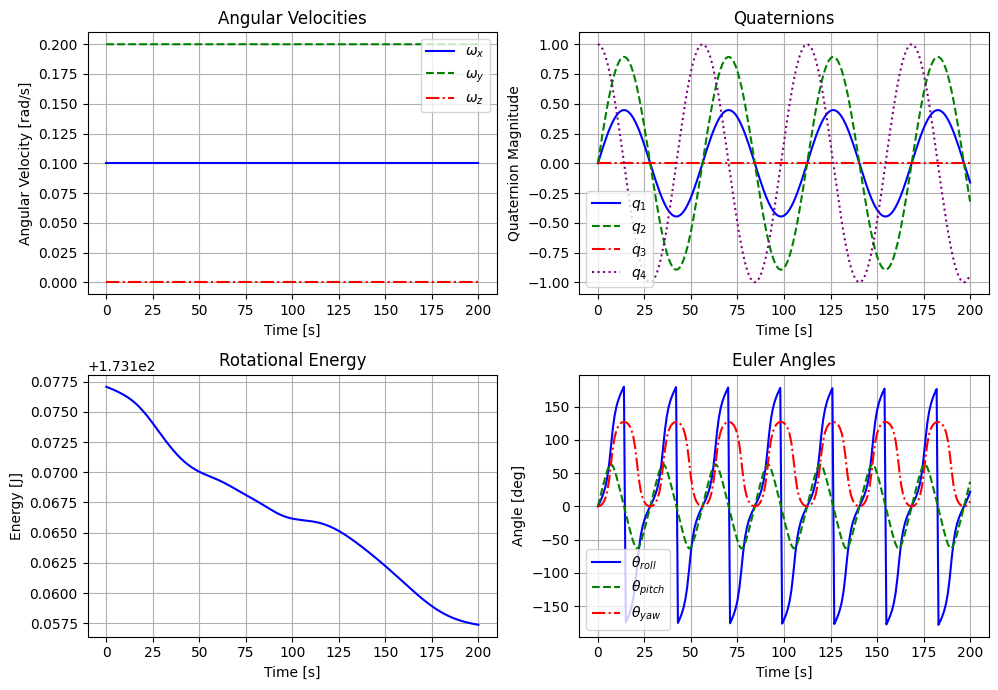

In [7]:
attitude.plot(["angular_velocity", "quaternions", "energy", "euler_angles"])

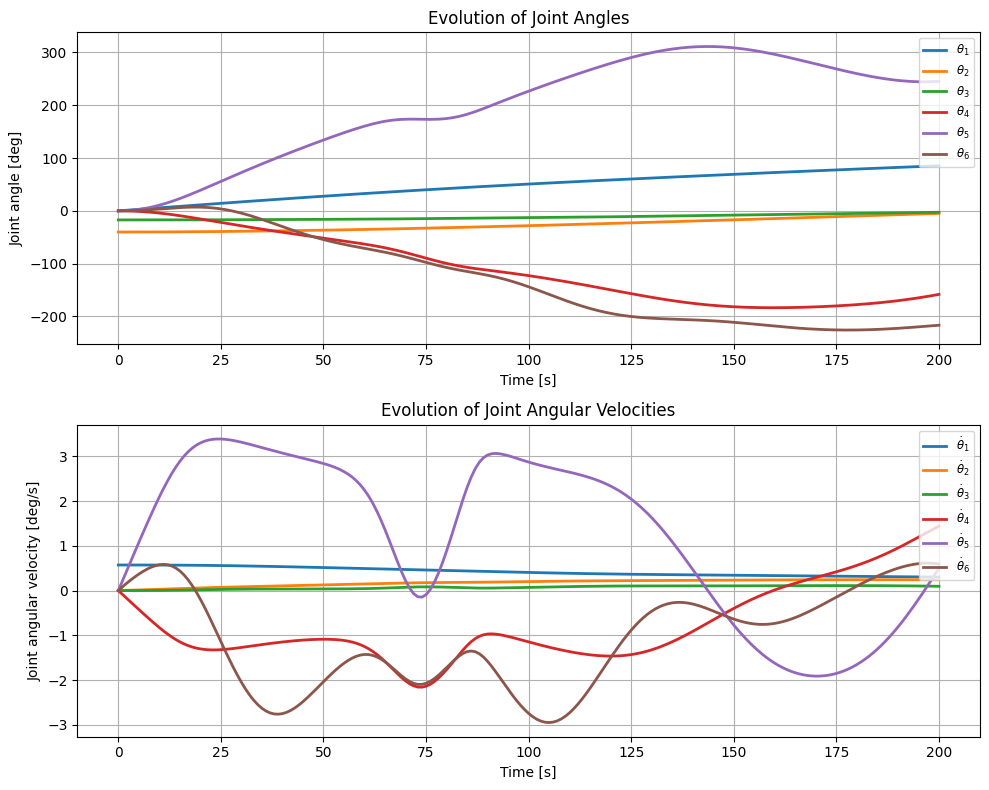

In [8]:
arm.plot()

- Animation rendering progress -
[=====================]  100.00% (201/201) ETA: 0m 0s


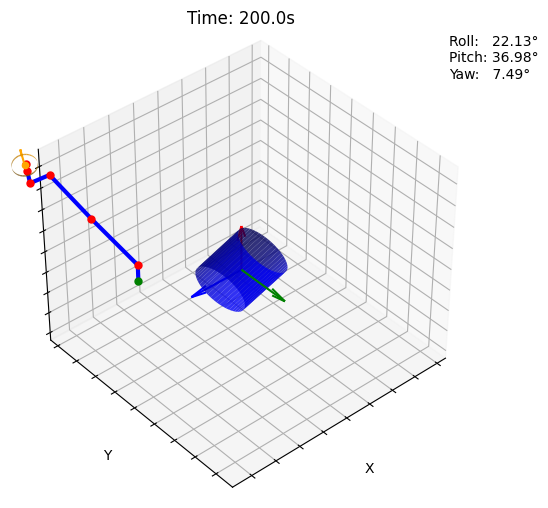

In [9]:
animate_system(
    t=attitude.t,
    q=attitude.q,
    eu=attitude.euler_angles,
    h=debris.height,
    r=debris.radius,
    dpi=300,
    arms=[arm],
    dh_par=joints
)